# Explore Dali Data Pipelines

## Things we need to do
- Verify that we are sharding properly
- Verify the operations that we are running

In [4]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.types as types
import nvidia.dali.fn as fn

In [13]:
image_dir = '../../cv_data/cifar10/train'
batch_size = 4

## Single Pipeline

In [14]:
# example single pipeline
def test_pipeline(device_id):
    pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=device_id)
    with pipe:
        jpegs, labels = fn.file_reader(file_root=image_dir, random_shuffle=False)
        images = fn.image_decoder(jpegs, device='mixed', output_type=types.RGB)

        pipe.set_outputs(images, labels)

    return pipe

In [15]:
# Create and build the pipeline
pipe = test_pipeline(device_id = 1)
pipe.build()

# Run pipeline on selected device
images, labels = pipe.run()

In [43]:
images.shape

torch.Size([4, 3, 300, 300])

In [16]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

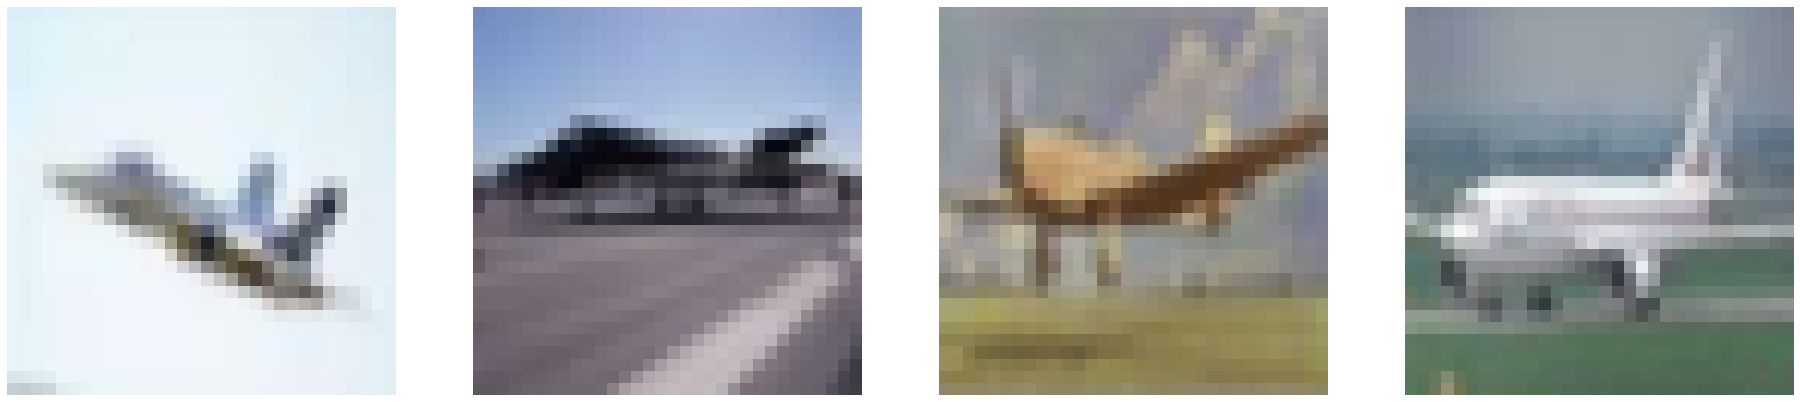

In [17]:
show_images(images.as_cpu())

## Multi-pipeline

In [19]:
def sharded_pipeline(device_id, shard_id, num_shards):
    pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=device_id)
    with pipe:
        jpegs, labels = fn.file_reader(
            file_root=image_dir, random_shuffle=False, shard_id=shard_id, num_shards=num_shards)
        images = fn.image_decoder(jpegs, device='mixed', output_type=types.RGB)

        pipe.set_outputs(images, labels)

    return pipe

In [20]:
# Create and build pipelines
pipe_one = sharded_pipeline(device_id=0, shard_id=0, num_shards=2)
pipe_one.build()

pipe_two = sharded_pipeline(device_id=1, shard_id=1, num_shards=2)
pipe_two.build()

# Run pipelines
images_one, labels_one = pipe_one.run()
images_two, labels_two = pipe_two.run()

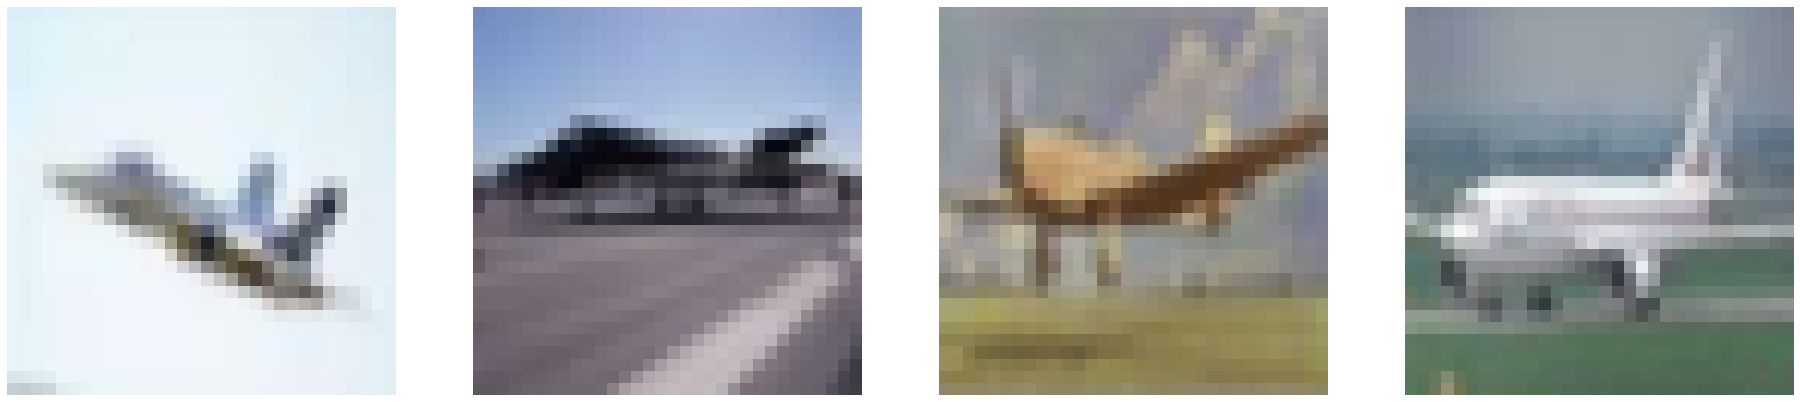

In [21]:
show_images(images_one.as_cpu())

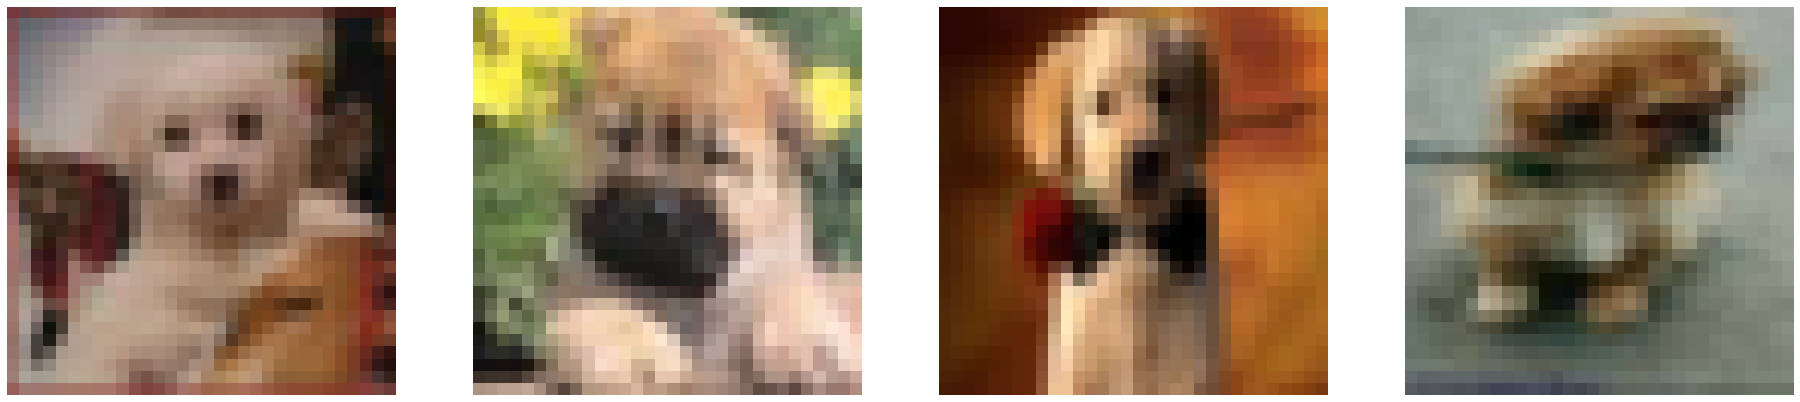

In [23]:
show_images(images_two.as_cpu())

# Testing a DataLoader

In [39]:
from torchvision.datasets import ImageFolder
from pytorch_lightning import LightningDataModule
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

In [30]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

data_transform = transforms.Compose([
            transforms.Resize((300,300)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

train_data = ImageFolder(
        #root=os.path.join(cifar100, 'train'),
        root=image_dir,
        transform = data_transform
    )

In [35]:
## normal dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, 
                                num_workers=4)

In [37]:
load_test = iter(train_loader)
images, labels = load_test.next()

In [44]:
images.shape

torch.Size([4, 3, 300, 300])

In [50]:
def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(np.transpose(image_batch[j].numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


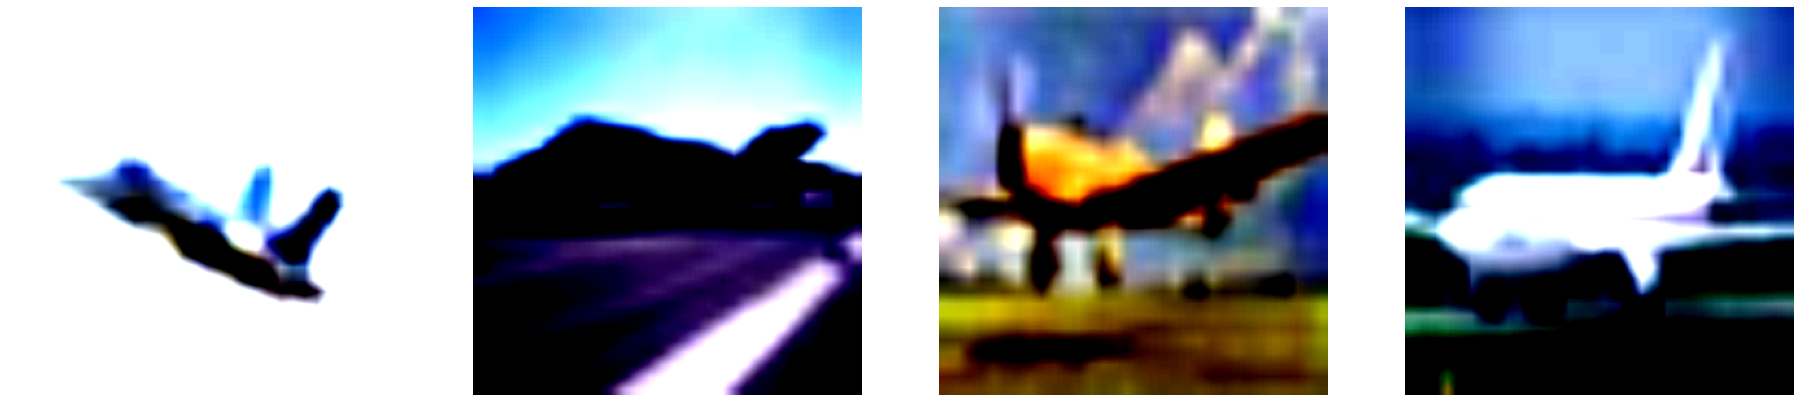

In [53]:
# values are a bit off due to normalise probably?
show_images(images)

## PyTorch Lightning DataLoader

In [54]:
class PLDataLoader(LightningDataModule):
    def __init(self):
        super().__init__()
        
    def prepare
        
    def setup(self, stage=None):
        pass
    
    def train_dataloader(self):
        pass